# Logistic Regression: quick review

We'll denote the label as $Y$, and the set of observed features as a feature vector 
$x = [x_1, x_2,\ldots x_d]$.

We define $Y=1$ if an individual earned > 50,000 dollars and $Y=0$ otherwise.

In Logistic Regression, the probability of the label being positive ($Y=1$) given the features 
$x$ is given as:

\begin{equation}
P(Y = 1 ~| ~X) = \frac{1}{ 1 + \exp(- (w^\top x + b))}
\end{equation}

where:
- $w = [w_1, w_2, \ldots, w_d]$ are the model weights.
- $b$ is the bias of the model.

**Linear Model**

- we can see that:
$w^\top x + b = b + w_1 x_1 + \ldots + w_d x_d$
is a linear model where the output is a linear function of the input features 
$x$. 

- The bias $b$ is the prediction one would make without observing any features. 

- The model weight $w_i$ reflects how the feature $x_i$ is correlated with the positive label. 

- If $x_i$ is positively correlated with the positive label, the weight $w_i$ increases, and the probability $P(Y=1|x)$ will be closer to 1. 

- If $x_i$ is negatively correlated with the positive label, then the weight $w_i$ decreases and the probability $P(Y = 1 | x)$ will be closer to 0.

**Logistic Function**  (aka the *sigmoid* function) 

\begin{equation}
S(t) = \frac{1}{1 + \exp(-t))}
\end{equation}

- applied to the linear model. 

- converts the output of the linear model $w^\top x + b$ from any real number into the range of $[0, 1]$, which can be interpreted as a probability.

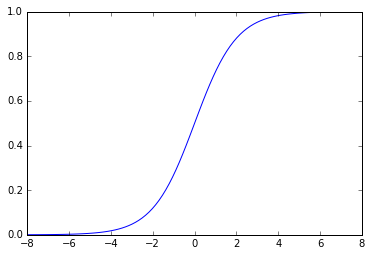

In [203]:
# Let's plot the logistic function.
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

xx = np.linspace(-8, 8, 100)
yy = np.divide(1, 1 + np.exp(-xx))
plt.plot(xx, yy)

***Model training*** is an optimization problem:

The goal is to find a set of model weights (i.e. model parameters) to minimize a loss function (typically the cross entropy) defined over the training data.

# Description of the sparse data

The dataset we'll be using is the [Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income).

In [173]:
import tempfile
import urllib
train_file = tempfile.NamedTemporaryFile()
test_file = tempfile.NamedTemporaryFile()
urllib.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", train_file.name)
urllib.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test", test_file.name)

('/tmp/tmp4gT4Sy', <httplib.HTTPMessage instance at 0x7f633e8bfd40>)

Once the CSV files are downloaded, let's read them into [Pandas](http://pandas.pydata.org/) dataframes.

In [174]:
import pandas as pd

In [175]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]
df_train = pd.read_csv(train_file, names=COLUMNS, skipinitialspace=True)
df_test = pd.read_csv(test_file, names=COLUMNS, skipinitialspace=True, skiprows=1)

In [176]:
print df_train.shape

(32561, 15)


In [177]:
print df_test.shape

(16281, 15)


We have:
- 32561 training data samples
- 16281 test data samples

**Binary classification** problem, where the label is:
* 1 if the income is over 50K
* 0 otherwise

We will construct a label column named "label" whose value is 1 if the income is over 50K, and 0 otherwise.

In [178]:
LABEL_COLUMN = "label"
df_train[LABEL_COLUMN] = (df_train["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)
df_test[LABEL_COLUMN] = (df_test["income_bracket"].apply(lambda x: ">50K" in x)).astype(int)

The columns can be grouped into two types **categorical** and **continuous** columns:

* A column is called **categorical** if its value can only be one of the categories in a finite set (e.g., country)
* A column is called **continuous** if its value can be any numerical value in a continuous range. 

In [179]:
CATEGORICAL_COLUMNS = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "gender", "native_country"]
CONTINUOUS_COLUMNS = ["age", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

Here's a list of columns we will use from the Census Income dataset:


| Column Name   | Type          | Description      |
| ------------- |:-------------:| ---------------|
| age	| Continuous |	The age of the individual |
| workclass	| Categorical	| The type of employer the individual has |
| education | Categorical | The highest level of education achieved for that individual |
| education_num | Continuous | The highest level of education in numerical form |
| marital_status | Categorical | Marital status of the individual |
| occupation | Categorical | The occupation of the individual |
| relationship | Categorical | Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried |
| race | Categorical | White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black |
| gender | Categorical | Female, Male |
| capital_gain | Continuous | Capital gains recorded |
| capital_loss | Continuous | Capital Losses recorded |
| hours_per_week | Continuous | Hours worked per week |
| native_country | Categorical | Country of origin of the individual |
| income | Categorical |	">50K" or "<=50K" |


# Converting Data into Tensors

The input data is specified by means of an Input Builder function.  This builder function will not be called until it is later passed to TF.Learn methods such as *fit* and *evaluate*.

This Input Builder function returns the following as a pair:
* **feature_cols**: A dict from feature column names to [Tensors](https://www.tensorflow.org/versions/r0.9/api_docs/python/framework.html#Tensor) or [SparseTensors](https://www.tensorflow.org/versions/r0.9/api_docs/python/sparse_ops.html#SparseTensor).
* **label**: A Tensor containing the label column.


* Each continuous column in the train or test dataframe will be converted into a Tensor, which in general is a good format to represent dense data. 
* For categorical data, we must represent the data as a SparseTensor. This data format is good for representing sparse data.

In [180]:
import tensorflow as tf

def input_fn(df):
  # Creates a dictionary mapping from each continuous feature column name (k) to
  # the values of that column stored in a constant Tensor.
  continuous_cols = {k: tf.constant(df[k].values)
                     for k in CONTINUOUS_COLUMNS}
  # Creates a dictionary mapping from each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
  categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(df[k].size)],
      values=df[k].values,
      shape=[df[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
  feature_cols = dict(continuous_cols.items() + categorical_cols.items())
  # Converts the label column into a constant Tensor.
  label = tf.constant(df[LABEL_COLUMN].values)
  # Returns the feature columns and the label.
  return feature_cols, label

def train_input_fn():
  return input_fn(df_train)

def eval_input_fn():
  return input_fn(df_test)

# Feature Engineering

---
##### Selecting the right set of feature columns is key to learning an effective model!
---

We distinguish between

* **Base** feature columns: a raw column in the original dataframe

* **Derived** feature columns: any new columns created based on some transformations defined over one or multiple base columns

### Base Categorical Feature Columns

To define a feature column for a categorical feature, we can create a **SparseColumn** using the TF.Learn API.

* If you know the set of all possible feature values of a column and there are only a few of them, you can use **sparse_column_with_keys**. 
* Each key in the list will get assigned an auto-incremental ID starting from 0.

In [181]:
import tensorflow as tf

gender = tf.contrib.layers.sparse_column_with_keys(column_name="gender",
                                                   keys=["female", "male"])

What if we don't know the set of possible values in advance? 

We can use **sparse_column_with_hash_bucket** instead.

In [182]:
education = tf.contrib.layers.sparse_column_with_hash_bucket("education",
                                                             hash_bucket_size=1000)

Each possible value in the feature column education will be hashed to an integer ID as we encounter them in training. For example:


| ID     | Feature    |
| ------ |------------|
| ...    | ...  |
| 9      | "Bachelors" |
| ...    | ...  |
| 103    | "Doctorate" |
| ...    | ...  |
| 375    | "Masters" |

* Each feature string will be mapped into an integer ID by looking up a fixed mapping or by hashing
* Hashing collisions are possible (but may not significantly impact the model quality)

* Under the hood, the LinearModel class is responsible for managing the mapping and creating **tf.Variable** to store the model parameters (also known as model weights) for each feature ID. 
* The model parameters will be learned through the model training process we'll go through later.

We'll do the similar trick to define the other categorical features:

In [183]:
race = tf.contrib.layers.sparse_column_with_keys(column_name="race", keys=[
  "Amer-Indian-Eskimo", "Asian-Pac-Islander", "Black", "Other", "White"])
marital_status = tf.contrib.layers.sparse_column_with_hash_bucket("marital_status", hash_bucket_size=100)
relationship = tf.contrib.layers.sparse_column_with_hash_bucket("relationship", hash_bucket_size=100)
workclass = tf.contrib.layers.sparse_column_with_hash_bucket("workclass", hash_bucket_size=100)
occupation = tf.contrib.layers.sparse_column_with_hash_bucket("occupation", hash_bucket_size=1000)
native_country = tf.contrib.layers.sparse_column_with_hash_bucket("native_country", hash_bucket_size=1000)

### Base Continuous Feature Columns

Similarly, we can define a **RealValuedColumn** for each continuous feature column that we want to use in the model:

In [184]:
age = tf.contrib.layers.real_valued_column("age")
education_num = tf.contrib.layers.real_valued_column("education_num")
capital_gain = tf.contrib.layers.real_valued_column("capital_gain")
capital_loss = tf.contrib.layers.real_valued_column("capital_loss")
hours_per_week = tf.contrib.layers.real_valued_column("hours_per_week")

### Making Continuous Features Categorical through Bucketization

Sometimes the relationship between a continuous feature and the label is not linear. 

As an hypothetical example, a person's income may grow with age in the early stage of one's career, then the growth may slow at some point, and finally the income decreases after retirement. In this scenario, using the raw age as a real-valued feature column might not be a good choice because the (linear) model can only learn one of the three cases:

1. Income always increases at some rate as age grows (positive correlation),
2. Income always decreases at some rate as age grows (negative correlation), or
3. Income stays the same no matter at what age (no correlation)

If we want to learn the fine-grained correlation between income and each age group seperately, we can leverage **bucketization**. 

---
##### Bucketization is a process of dividing the entire range of a continuous feature into a set of consecutive bins/buckets, and then converting the original numerical feature into a bucket ID (as a categorical feature) depending on which bucket that value falls into
---

So, we can define a **bucketized_column** over age as:

In [185]:
age_buckets = tf.contrib.layers.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

In this case, there are 10 boundaries, resulting in 11 age group buckets (from age 17 and below, 18-24, 25-29, ..., to 65 and over).

### Intersecting Multiple Columns with CrossedColumn

- Using each feature column separately may not be enough to explain the data 

- For example, the correlation between education and the label (earning > 50,000 dollars) may be different for different occupations (e.g. we want to distinguish between *education="Bachelors"* AND *occupation="Exec-managerial"* and *education="Bachelors" AND occupation="Craft-repair"*)

- To learn the differences between different feature combinations, we can add crossed feature columns to the model

In [186]:
education_x_occupation = tf.contrib.layers.crossed_column([education, occupation], hash_bucket_size=int(1e4))

We can also create a **CrossedColumn** over more than two columns. Each constituent column can be either a base feature column that is categorical (SparseColumn), a bucketized real-valued feature column (BucketizedColumn), or even another CrossColumn.

For example:

In [187]:
age_buckets_x_race_x_occupation = tf.contrib.layers.crossed_column(
  [age_buckets, race, occupation], hash_bucket_size=int(1e6))

# The Logistic Regression Model

In the previous section we've seen several types of base and derived feature columns, including:

* SparseColumn
* RealValuedColumn
* BucketizedColumn
* CrossedColumn

All of these are subclasses of the abstract **FeatureColumn** class, and can be added to the feature_columns field of a model:

In [188]:
model_dir = tempfile.mkdtemp()
m = tf.contrib.learn.LinearClassifier(feature_columns=[
  gender, native_country, education, occupation, workclass, marital_status, race,
  age_buckets, education_x_occupation, age_buckets_x_race_x_occupation],
  model_dir=model_dir)

The model also automatically learns a bias term

The learned model files will be stored in *model_dir*

# Model training and evaluation

Training a model is just a one-liner using the TF.Learn API:

In [189]:
m.fit(input_fn=train_input_fn, steps=200)

LinearClassifier()

After the model is trained, we can evaluate how good our model is at predicting the labels of the holdout data:

In [190]:
results = m.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print "%s: %s" % (key, results[key])

accuracy: 0.836128
eval_auc: 0.882511
loss: 0.353698


# Exercise1 : Add more features and transformations

In [192]:
education_x_country = tf.contrib.layers.crossed_column([education, native_country], hash_bucket_size=int(1e4))

capital_gain_buckets = tf.contrib.layers.bucketized_column(
    capital_gain, boundaries=[5000, 20000, 30000, 50000, 70000, 100000])

model_dir = tempfile.mkdtemp()

m_more = tf.contrib.learn.LinearClassifier(feature_columns=[
  gender, native_country, education, occupation, workclass, marital_status, race,
  age_buckets, education_x_occupation, education_x_country, age_buckets_x_race_x_occupation,
    capital_gain_buckets],
  model_dir=model_dir)


In [193]:
m_more.fit(input_fn=train_input_fn, steps=200)

LinearClassifier()

In [201]:
results_more = m_more.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results_more):
    print "%s: %s" % (key, results_more[key])

accuracy: 0.849149
eval_auc: 0.899432
loss: 0.329421


# Adding Regularization against over-fitting

- Regularization is a technique used to avoid *overfitting*. 

- Overfitting happens when your model does well on the data it is trained on, but worse on test data that the model has not seen before, such as live traffic. 

- Overfitting generally occurs when a model is excessively complex, such as having too many parameters relative to the number of observed training data. 

- Regularization allows for you to control your model's complexity and makes the model more generalizable to unseen data.

In the Linear Model library, you can add L1 and L2 regularizations to the model as:

In [195]:
model_dir = tempfile.mkdtemp()

m_reg = tf.contrib.learn.LinearClassifier(feature_columns=[
  gender, native_country, education, occupation, workclass, marital_status, race,
  age_buckets, education_x_occupation, age_buckets_x_race_x_occupation],
  optimizer=tf.train.FtrlOptimizer(
    learning_rate=0.1,
    l1_regularization_strength=1.0,
    l2_regularization_strength=1.0),
  model_dir=model_dir)

- L1 regularization tends to make model weights stay at zero (creating sparser models)

- L2 regularization also tries to make the model weights closer to zero but not necessarily zero. 

Therefore, if you increase the strength of L1 regularization, you will have a smaller model size because many of the model weights will be zero. This is often desirable when the feature space is very large but sparse, and when there are resource constraints that prevent you from serving a model that is too large.

In practice, you should try various combinations of L1, L2 regularization strengths and find the best parameters that best control overfitting and give you a desirable model size.

In [196]:
m_reg.fit(input_fn=train_input_fn, steps=200)

LinearClassifier()

In [197]:
results = m_reg.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print "%s: %s" % (key, results[key])

accuracy: 0.814815
eval_auc: 0.85803
loss: 0.401218
